# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

# Test MediaPipe Function with real camera 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('DATASET') 

# Actions that we try to detect
actions = np.array(['None', 'Thank You', 'Sorry', "That's OK", 'Fine', 
                    'GoodLuck', 'Think of', 'Cute', "Beaufiful", 'Like', 
                    'Dislike', 'Love', 'Clever', "Intelligent", 'Sick',
                    'Sad','Regret', 'Hungry', "Full", 'Understand'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [8]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 204, 102), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 204, 102), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,204, 102), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# Prepare Data for train and test

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [ ]:
X_train.shape

# Train model

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout

In [ ]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# log_dir_lstm = os.path.join('Logs')
# tb_callback_lstm = TensorBoard(log_dir=log_dir_lstm)

# log_dir_gru = os.path.join('Logs')
# tb_callback_gru = TensorBoard(log_dir=log_dir_gru
#                           )
# log_dir_bilstm = os.path.join('Logs')
# tb_callback_bilstm = TensorBoard(log_dir=log_dir_bilstm)

Train LSTM Model

In [13]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(192, return_sequences=True, activation='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(128, return_sequences=False, activation='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(32, activation='relu'))
model_LSTM.add(Dense(actions.shape[0], activation='softmax'))

model_LSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=620)

Epoch 1/620
12/12 [==============================] - 7s 245ms/step - loss: 3.1744 - categorical_accuracy: 0.0611 - val_loss: 3.0790 - val_categorical_accuracy: 0.0542
Epoch 2/620
12/12 [==============================] - 2s 199ms/step - loss: 3.0362 - categorical_accuracy: 0.0611 - val_loss: 2.9984 - val_categorical_accuracy: 0.0958
Epoch 3/620
12/12 [==============================] - 2s 190ms/step - loss: 3.0089 - categorical_accuracy: 0.0500 - val_loss: 2.9915 - val_categorical_accuracy: 0.0958
Epoch 4/620
12/12 [==============================] - 2s 179ms/step - loss: 2.9763 - categorical_accuracy: 0.0833 - val_loss: 2.9662 - val_categorical_accuracy: 0.1125
Epoch 5/620
12/12 [==============================] - 2s 176ms/step - loss: 2.9603 - categorical_accuracy: 0.0611 - val_loss: 2.9170 - val_categorical_accuracy: 0.0958
Epoch 6/620
12/12 [==============================] - 2s 179ms/step - loss: 2.9087 - categorical_accuracy: 0.0861 - val_loss: 2.8672 - val_categorical_accuracy: 0.087

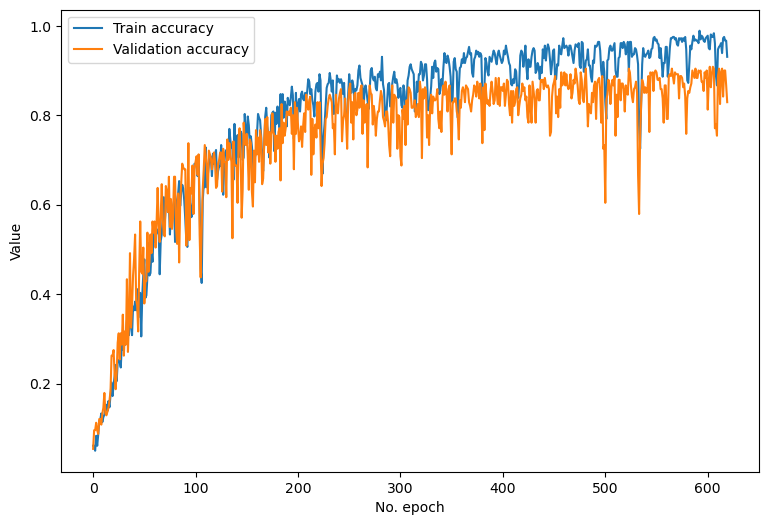

In [14]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_LSTM.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()
# plt.savefig('Model/LSTM/plt_LSTM.png')

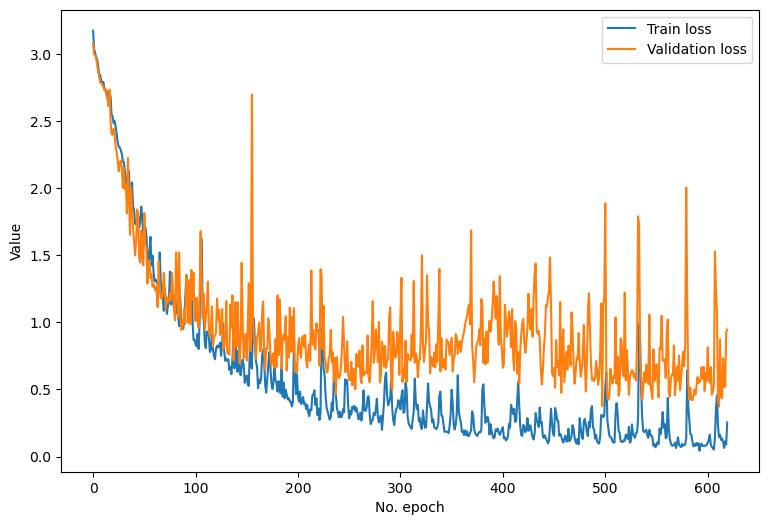

In [15]:
plt.figure(figsize=(9,6))
plt.plot(model_LSTM.history.history['loss'], label='Train loss')
plt.plot(model_LSTM.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [16]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           916992    
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 192)           246528    
                                                                 
 dropout_1 (Dropout)         (None, 30, 192)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               164352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [17]:
model_LSTM.save('Model/LSTM/LSTM_Model.h5')

In [18]:
model_LSTM.load_weights('Model/LSTM/LSTM_Model.h5')

In [20]:
# model_LSTM = load_model('Model/LSTM/LSTM_Model.h5')

Train GRU Model

In [ ]:
model_GRU = Sequential()
model_GRU.add(LSTM(192, return_sequences=True, activation='relu', input_shape=(30,1662)))
model_GRU.add(LSTM(256, return_sequences=True, activation='relu'))
model_GRU.add(LSTM(128, return_sequences=False, activation='relu'))
model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(Dense(32, activation='relu'))
model_GRU.add(Dense(actions.shape[0], activation='softmax'))

model_GRU.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_GRU.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=300)

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(model_GRU.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_GRU.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(model_GRU.history.history['loss'], label='Train loss')
plt.plot(model_GRU.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
model_GRU.summary()

In [ ]:
model_GRU.save('Model/GRU/GRU_Model.h5')

In [ ]:
model_GRU.load_weights('Model/GRU/GRU_Model.h5')

Train BiLSTM Model

In [ ]:
model_BiLSTM = Sequential()
model_BiLSTM.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(30,1662)))# Add a dropout layer with a rate of 0.2
model_BiLSTM.add(LSTM(512, return_sequences=True, activation='relu'))
model_BiLSTM.add(LSTM(256, return_sequences=False, activation='relu'))
model_BiLSTM.add(Dense(64, activation='relu'))
model_BiLSTM.add(Dense(32, activation='relu'))
model_BiLSTM.add(Dense(actions.shape[0], activation='softmax'))

model_BiLSTM.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_BiLSTM.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=100)

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(model_BiLSTM.history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(model_BiLSTM.history.history['val_categorical_accuracy'], label='Validation accuracy')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(model_BiLSTM.history.history['loss'], label='Train loss')
plt.plot(model_BiLSTM.history.history['val_loss'], label='Validation loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
model_BiLSTM.summary()

In [ ]:
model_BiLSTM.save('Model/BiLSTM/BiLSTM_Model.h5')

In [ ]:
model_BiLSTM = load_model('Model/BiLSTM/BiLSTM_Model.h5')

In [31]:
from sklearn.metrics import multilabel_confusion_matrix

Test Accuracy Model

In [19]:
yhat = model_LSTM.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_LSTM.evaluate(X_train, y_train)
model_LSTM.evaluate(X_test, y_test)
# accuracy_score(ytrue, yhat)

8/8 [==============================] - 0s 43ms/step - loss: 0.9459 - categorical_accuracy: 0.8292


[0.9459030032157898, 0.8291666507720947]

In [ ]:
yhat = model_GRU.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_GRU.evaluate(X_train, y_train)
model_GRU.evaluate(X_test, y_test)

In [ ]:
yhat = model_BiLSTM.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

model_BiLSTM.evaluate(X_train, y_train)
model_BiLSTM.evaluate(X_test, y_test)

In [32]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[230,   0],
        [  0,  10]],

       [[225,   0],
        [  0,  15]],

       [[228,   0],
        [  0,  12]],

       [[230,   0],
        [  0,  10]],

       [[226,   0],
        [  0,  14]],

       [[234,   0],
        [  0,   6]],

       [[229,   1],
        [  0,  10]],

       [[225,   0],
        [  0,  15]],

       [[223,   1],
        [  3,  13]],

       [[226,   1],
        [  1,  12]],

       [[224,   0],
        [  1,  15]],

       [[226,   0],
        [  0,  14]],

       [[235,   0],
        [  0,   5]],

       [[228,   0],
        [  1,  11]],

       [[226,   0],
        [  0,  14]],

       [[224,   3],
        [  1,  12]],

       [[230,   1],
        [  0,   9]],

       [[224,   0],
        [  1,  15]],

       [[228,   1],
        [  0,  11]],

       [[231,   0],
        [  0,   9]]], dtype=int64)

# Test Model in real time

In [ ]:
colors = (0, 204, 102)
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*50), 90+num*40), colors, -1)
        cv2.putText(output_frame, actions[num], (0, 60+num*20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [29]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model_LSTM.predict(np.expand_dims(sequence, axis=0))[0]
#             print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1: 
                sentence = sentence[-1:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step
